In [27]:
import os
import glob
import cv2
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics import mean_absolute_error

# --- ตั้ง path ของโมเดล RandomForest ---
RF_MODEL_PATH = r"d:\Coding\Python\Project\eyeCenter\train\rf_model.joblib"

# --- ตั้ง path ของ dataset ---
IMG_DIR = r"d:\Coding\Python\Project\eyeCenter\data\Right\Image144x144"
ANN_DIR = r"d:\Coding\Python\Project\eyeCenter\data\Right\Annotation144x144"

In [28]:
def is_number(s):
    try:
        float(s)
        return True
    except:
        return False


In [29]:
# --- โหลด data ขนาดจริง 144x144 แต่ยังใช้ HOG 64x64 ---
IMG_SIZE = (64,64)  # HOG input
IMG_REAL = (144,144)  # ขนาด original

X, Y, imgs_raw = [], [], []
imgs = sorted(glob.glob(os.path.join(IMG_DIR.replace("64x64","144x144"), "*.jpg")))

for p in imgs:
    base = os.path.splitext(os.path.basename(p))[0]
    annp = os.path.join(ANN_DIR.replace("64x64","144x144"), base+".txt")
    if not os.path.exists(annp):
        continue
    with open(annp,"r") as f:
        toks = []
        for line in f:
            toks += line.strip().split()
    nums = [float(t) for t in toks if is_number(t)]
    if len(nums)<2: continue
    y = [nums[0], nums[1]]
    im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if im is None: continue
    imgs_raw.append(im)
    # resize for HOG (64x64)
    imr = cv2.resize(im, IMG_SIZE)
    feats = hog(imr, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
    X.append(feats)
    Y.append(y)

X = np.asarray(X)
Y = np.asarray(Y)

# Predict
y_pred = rf.predict(X)

# scale to 144x144
SCALE = 144/64
Y_scaled = Y * SCALE
y_pred_scaled = y_pred * SCALE

mae_144 = mean_absolute_error(Y_scaled, y_pred_scaled)
print(f"RF pixel MAE (144x144): {mae_144:.4f}")


RF pixel MAE (144x144): 2.7777


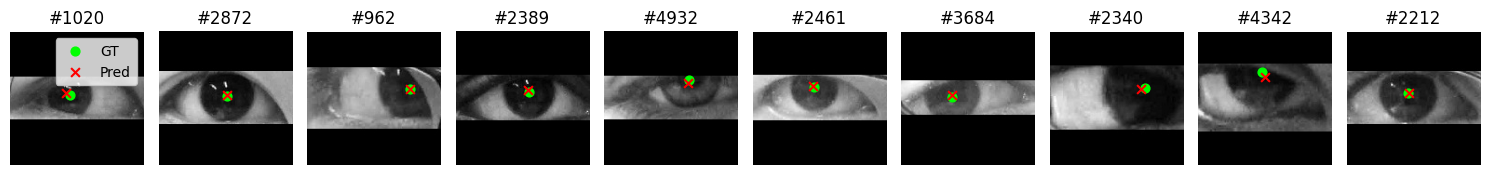

In [30]:
# จำนวนภาพที่จะแสดง
plot_num = 10
idxs = random.sample(range(len(imgs_raw)), min(plot_num, len(imgs_raw)))

fig, axes = plt.subplots(1, len(idxs), figsize=(15, 3))
if len(idxs) == 1:
    axes = [axes]   

for i, ax in enumerate(axes):
    idx = idxs[i]
    img = imgs_raw[idx]
    ax.imshow(img, cmap='gray')
    # GT
    ax.scatter(Y[idx][0], Y[idx][1], c="lime", marker="o", s=40, label="GT")
    # Pred
    ax.scatter(y_pred[idx][0], y_pred[idx][1], c="red", marker="x", s=40, label="Pred")
    ax.set_title(f"#{idx}")
    ax.axis("off")

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()
